## Семинар 9: "LSTM"

ФИО: Намит Максим Михайлович

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/data/timeseries/

/content/drive/MyDrive/data/timeseries


In [3]:
!pip install pytorch_forecasting

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from pytorch_forecasting.metrics import MAPE
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.metrics import mean_absolute_percentage_error
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = torch.autograd.Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

In [6]:
from IPython.display import clear_output
import sys

In [7]:
def train_network(network, train_loader, loss, epochs, learning_rate, hidden_size, device='cuda', num_layers=1):
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    network = network.to(device)
    network.train()
    try:
        for epoch in range(epochs):
            losses = []
            network.zero_grad()
            for X, y in train_loader:
              X = X.type(dtype = torch.FloatTensor)
              X = X.to(device)
              y = y.to(device)
              hidden = (torch.zeros(1, 1, network.hidden_size).to(device),
                        torch.zeros(1, 1, network.hidden_size).to(device))
              prediction, _ = network(X, hidden)
              loss_step = loss(y.to(device), prediction.to(device))
              optimizer.zero_grad()
              loss_step.backward()
              optimizer.step()
  
            train_loss_epochs.append(loss_step)
            clear_output(True)
            sys.stdout.write('\rEpoch {0}... (Train) LOSS: {1:.3f}'.format(
                            epoch, train_loss_epochs[-1]))
            plot = True
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

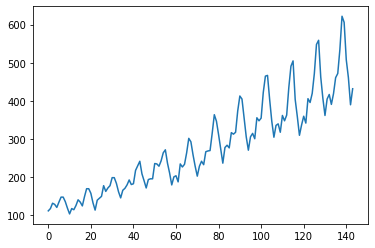

In [8]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [9]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [10]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


In [11]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [12]:
# Пример подготовленных данных

look_back = 15
look_forward= 2
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))

In [14]:
train_dataloader =  DataLoader(train_dataset, batch_size=5)

In [15]:
test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))

In [16]:
test_dataloader =  DataLoader(test_dataset, batch_size=5)

In [17]:
lstm =  nn.LSTM(hidden_size=look_forward, input_size=look_back)

Epoch 99... (Train) LOSS: 0.015

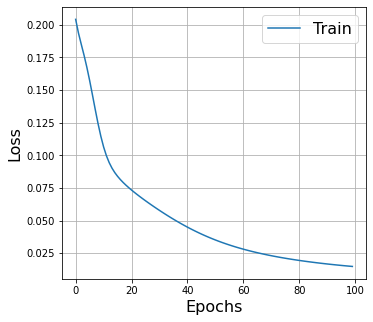

[tensor(0.2041, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.1936, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.1850, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.1766, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.1675, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.1573, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.1464, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.1351, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.1244, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.1147, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.1064, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0997, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0944, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0902, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0868, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0839, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0814, device='

In [18]:
train_network(lstm, train_dataloader, nn.MSELoss(), 100, 0.001, look_forward)

In [19]:
my_lstm = LSTM(hidden_size=look_forward, input_size=look_back)

Epoch 99... (Train) LOSS: 0.008

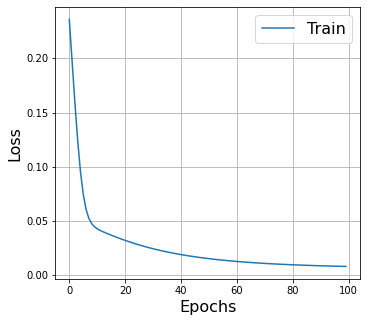

[tensor(0.2359, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.1976, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.1594, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.1244, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0956, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0745, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0607, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0524, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0476, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0447, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0428, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0413, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0401, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0390, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0379, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0369, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0359, device='

In [20]:
train_network(my_lstm, train_dataloader, nn.MSELoss(), 100, 0.001, look_forward)

In [21]:
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

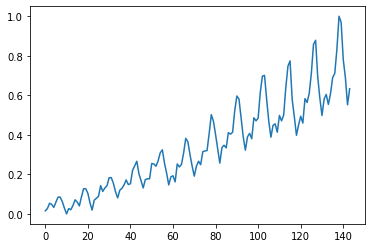

In [22]:
ovr = np.hstack((train[:, 0], test[:, 0]))
plt.plot(ovr)

In [23]:
def return_predicted(model, hidden_size, device='cpu'):
    hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
              torch.ones(1, 1, model.hidden_size).to(device))
    predicted = []
    model.to(device)
    model.zero_grad()
    for x, y in test_dataloader:
        predY, hidden = model(x.to(device), hidden)
        predicted += list(predY[:, 0, 0])
    return predicted

def plot_model(model, ovr, test, hidden_size, device='cpu'):
    pred = return_predicted(model, test, device)
    pred = [i.item() for i in pred]
    ovr[-len(pred):] = pred
    plt.plot(ovr)

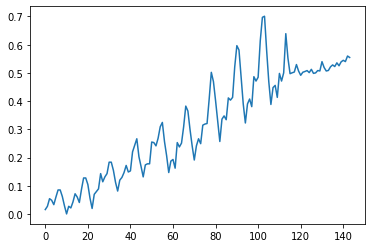

In [24]:
plot_model(lstm, ovr, test_dataloader, look_forward, 'cuda')

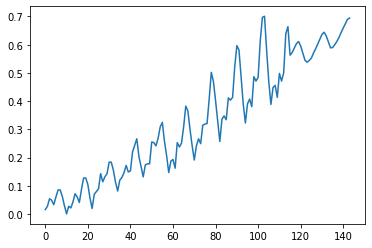

In [25]:
plot_model(my_lstm, ovr, look_forward, 'cuda')

## Задание 3 

Поучаствуйте в соревновании https://www.kaggle.com/t/374fc477c4744b009a837153ce135cfb 

Для зачета задания нужно получить значение MAPE меньше 0.2

До 1 мая 2021 можно получить 3,2,1 дополнительных балла за 1, 2 и 3 место соответственно.


Опиционально: сравните классические подходы (ARIMA, gradient boosting trees и RNN)

In [26]:
def train_network(network, train_loader, loss, epochs, learning_rate, hidden_size, device='cuda', num_layers=1):
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    losses = []
    network = network.to(device)
    network.train()
    try:
        for epoch in range(epochs):
            losses = []
            network.zero_grad()
            for X, y in train_loader:
              X = X.type(dtype = torch.FloatTensor)
              X = X.to(device)
              y = y.to(device)
              hidden = (torch.zeros(X.shape[1], network.hidden_size).to(device),
                        torch.zeros(X.shape[1], network.hidden_size).to(device))
              prediction = network(X, hidden)
              loss_step = loss(y.to(device), prediction.to(device))
              optimizer.zero_grad()
              loss_step.backward()
              optimizer.step()
              losses.append(loss_step.item())
  
            train_loss_epochs.append(np.mean(losses))
            clear_output(True)
            sys.stdout.write('\rEpoch {0}... (Train) LOSS: {1:.3f}'.format(
                            epoch, train_loss_epochs[-1]))
            plot = True
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs

In [27]:
class my_LSTM(nn.Module):
  def __init__(self, inp_size, hid_size, out_size):
        super(my_LSTM, self).__init__()
        self.hidden_size = hid_size
        self.output_size = out_size
        self.lstm        = LSTM(inp_size,  self.hidden_size)
        self.linear      = nn.Sequential(nn.Linear(self.hidden_size, 128))
        self.conv_blocks = nn.Sequential(nn.Conv2d(1, 32, 3, 2),
                                         nn.ReLU(),
                                         nn.Conv2d(32, 64, 3, 2),
                                         nn.ReLU())
        self.last_linear = nn.Sequential(nn.Linear(192, self.output_size))
      
  def forward(self, X, hidden):
        output, _ = self.lstm(X, hidden)
        output    = output.view(X.shape[0], -1)
        output    = self.linear(output.to('cuda'))
        output    = output.view(X.shape[0], 1, 8, 16)
        output    = self.conv_blocks(output)
        output    = output.view(X.shape[0], -1)
        output    = self.last_linear(output)
        return output

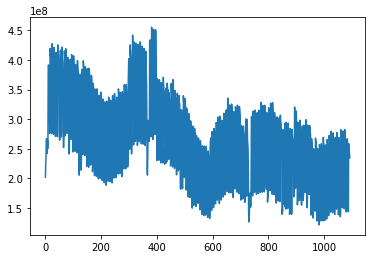

In [28]:
data_original = pandas.read_csv('train.csv', usecols=[1], delimiter=",", engine='python', skipfooter=3)
plt.plot(data_original)
plt.show()

In [29]:
data = data_original.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.values)

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

look_back = 65
look_forward = 1

trainX, trainY = create_dataset(data, look_back, look_forward)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
train_dataloader = DataLoader(train_dataset, batch_size=5)

In [30]:
model = my_LSTM(look_back, 120, look_forward)

Epoch 78... (Train) LOSS: 0.004

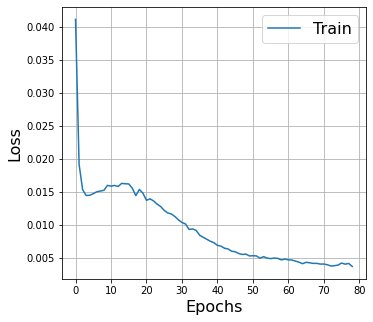

[0.04117963430347391,
 0.019215786030789547,
 0.015360641922633327,
 0.014479520772634643,
 0.014516863136979507,
 0.014755652978599808,
 0.015048961997997396,
 0.01515649858848316,
 0.015264871744416401,
 0.016014657194248074,
 0.015897404838274842,
 0.016002901017980072,
 0.015846245377546333,
 0.01631863906873459,
 0.016261580394447025,
 0.01623303234569479,
 0.015587700568838186,
 0.014460822456014497,
 0.015400630577345316,
 0.014829445229445553,
 0.013748193701970203,
 0.013978147560301649,
 0.013653996762531657,
 0.013171202107311455,
 0.01280765560431532,
 0.012228594370382992,
 0.011829683995546854,
 0.011686716528874437,
 0.011303203052396658,
 0.010793703282686392,
 0.010386269695109415,
 0.010171514111877594,
 0.009340296578786754,
 0.009415004933102466,
 0.009184911979194386,
 0.00845921685516798,
 0.008143069762473776,
 0.007852067454240948,
 0.00754668433835355,
 0.007331463591328023,
 0.006925048453021835,
 0.0068010436853442515,
 0.006491629894104706,
 0.00637701919687

In [31]:
train_network(model, train_dataloader, nn.MSELoss(), 100, 0.001, look_forward, 'cuda')

In [33]:
test = DataLoader(train_dataset, batch_size=1)

def return_predicted(network, test, device='cuda'):
    network = network.to(device)
    preds = []
    for X, y in test:
        X = X.type(dtype=torch.FloatTensor)
        hidden = (torch.zeros(X.shape[1], network.hidden_size).type(dtype=torch.FloatTensor).to(device),
                  torch.zeros(X.shape[1], network.hidden_size).type(dtype=torch.FloatTensor).to(device))
        X = X.to(device)
        out = network(X, hidden)
        preds.append(out)
    return preds

preds = return_predicted(model, test)

In [34]:
from sklearn.metrics import mean_absolute_error

In [35]:
mean_absolute_error(trainY, preds)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


0.10396585455182468

In [36]:
test = data[-look_back:]

In [37]:
def return_predicted(model, hidden_size, test, device = 'cuda'):
    predicted = []
    preds = []
    model.eval()
    for i in range(365):
        testX = []
        testX.append(test[i:i+hidden_size, 0])
        testX = np.array(testX)
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
        x = torch.tensor(testX).type(dtype=torch.FloatTensor)
        hidden = (torch.zeros(1, model.hidden_size).to(device),
              torch.zeros(1, model.hidden_size).to(device))
        pred = model(x.to(device), hidden)
        pred = pred.cpu().detach().numpy()
        preds.append(np.mean(pred))
        test = np.concatenate((test, np.array(pred).reshape(-1,1)), axis = 0)
    return preds

In [38]:
pred = return_predicted(model, look_back, test)
predicts = []
for i in pred:
    predicts.append([i])
true_pred = scaler.inverse_transform(predicts)
predicts = []
for i in true_pred:
    predicts.append(i[0])

In [39]:
import pandas as pd

In [40]:
df = pd.DataFrame()
df['date'] = pd.date_range("2019-01-01", periods=365, freq="D")
df['hits'] = predicts

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: